In [36]:
import os
import gc
import re
import math
import pickle
import joblib
import warnings

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.model_selection import KFold, GroupKFold

import xgboost as xgb

warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))# デフォルトは75%

In [37]:
import random as rn
import numpy as np


def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)

    rn.seed(seed)
    np.random.seed(seed)

In [38]:
from sklearn.metrics import mean_squared_log_error


def score(y, y_pred):
    RMSLE = np.sqrt(np.mean(((np.log(y + 1) - np.log(y_pred + 1)) ** 2)))
    #RMSLE = mean_squared_log_error(y, y_pred) ** 0.5
    return RMSLE

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt


def display_importances(
    importance_df,
    png_path=f"feature_importance.png",
):
    """feature_importance plot"""
    #importance_df.sort_values(by="importance", ascending=False).to_csv(
    #    f"feature_importance.csv"
    #)
    cols = (
        importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100]
        .index
    )
    best_features = importance_df.loc[importance_df.feature.isin(cols)]
    plt.figure(figsize=(8, 15))
    sns.barplot(
        x="importance",
        y="feature",
        data=best_features.sort_values(by="importance", ascending=False),
    )
    plt.title(f"XGBoost (avg over folds)   {png_path}")
    plt.tight_layout()
    plt.savefig(png_path)

In [40]:
import category_encoders as ce


def count_encoder(X_train, Y_train, X_val, Y_val, target_col: str, cat_features=None, features=None):
    """
    Count_Encoding: カテゴリ列をカウント値に変換する特徴量エンジニアリング（要はgroupby().size()の集計列追加のこと）
    ※カウント数が同じカテゴリは同じようなデータ傾向になる可能性がある
    https://www.kaggle.com/matleonard/categorical-encodings
    """
    X_train = pd.DataFrame(X_train, columns=features)
    Y_train = pd.DataFrame(Y_train, columns=[target_col])
    X_val = pd.DataFrame(X_val, columns=features)
    Y_val = pd.DataFrame(Y_val, columns=[target_col])
    
    train_df = X_train.join(Y_train)
    valid_df = X_val.join(Y_val)
    
    count_enc = ce.CountEncoder(cols=cat_features)

    # trainだけでfitすること(validationやtest含めるとリークする)
    count_enc.fit(train_df[cat_features])
    train_encoded = train_df.join(
        count_enc.transform(train_df[cat_features]).add_suffix("_count")
    )
    valid_encoded = valid_df.join(
        count_enc.transform(valid_df[cat_features]).add_suffix("_count")
    )

    features = train_encoded.drop(target_col, axis=1).columns.to_list()
    
    #return train_encoded, valid_encoded
    return train_encoded.drop(target_col, axis=1), valid_encoded.drop(target_col, axis=1), features



def target_encoder(X_train, Y_train, X_val, Y_val, target_col: str, cat_features=None, features=None):
    """
    Target_Encoding: カテゴリ列を目的変数の平均値に変換する特徴量エンジニアリング
    https://www.kaggle.com/matleonard/categorical-encodings
    """
    X_train = pd.DataFrame(X_train, columns=features)
    Y_train = pd.DataFrame(Y_train, columns=[target_col])
    X_val = pd.DataFrame(X_val, columns=features)
    Y_val = pd.DataFrame(Y_val, columns=[target_col])
    
    train_df = X_train.join(Y_train)
    valid_df = X_val.join(Y_val)

    target_enc = ce.TargetEncoder(cols=cat_features)

    # trainだけでfitすること(validationやtest含めるとリークする)
    target_enc.fit(train_df[cat_features], train_df[target_col])

    train_encoded = train_df.join(
        target_enc.transform(train_df[cat_features]).add_suffix("_target")
    )
    valid_encoded = valid_df.join(
        target_enc.transform(valid_df[cat_features]).add_suffix("_target")
    )
    
    features = train_encoded.drop(target_col, axis=1).columns.to_list()
    
    #return train_encoded, valid_encoded
    return train_encoded.drop(target_col, axis=1), valid_encoded.drop(target_col, axis=1), features


def catboost_encoder(X_train, Y_train, X_val, Y_val, target_col: str, cat_features=None, features=None):
    """
    CatBoost_Encoding: カテゴリ列を目的変数の1行前の行からのみに変換する特徴量エンジニアリング
    CatBoost使ったターゲットエンコーディング
    https://www.kaggle.com/matleonard/categorical-encodings
    """
    X_train = pd.DataFrame(X_train, columns=features)
    Y_train = pd.DataFrame(Y_train, columns=[target_col])
    X_val = pd.DataFrame(X_val, columns=features)
    Y_val = pd.DataFrame(Y_val, columns=[target_col])
    
    train_df = X_train.join(Y_train)
    valid_df = X_val.join(Y_val)

    cb_enc = ce.CatBoostEncoder(cols=cat_features, random_state=7)

    # trainだけでfitすること(validationやtest含めるとリークする)
    cb_enc.fit(train_df[cat_features], train_df[target_col])

    train_encoded = train_df.join(
        cb_enc.transform(train_df[cat_features]).add_suffix("_cb")
    )
    valid_encoded = valid_df.join(
        cb_enc.transform(valid_df[cat_features]).add_suffix("_cb")
    )
    
    features = train_encoded.drop(target_col, axis=1).columns.to_list()
    
    #return train_encoded, valid_encoded
    return train_encoded.drop(target_col, axis=1), valid_encoded.drop(target_col, axis=1), features

# Data load

In [41]:
import pandas as pd

DATADIR = r"C:\Users\81908\jupyter_notebook\poetry_work\tfgpu\atmaCup_#8\data\atmacup08-dataset"
train = pd.read_csv(f"{DATADIR}/train.csv")
test = pd.read_csv(f"{DATADIR}/test.csv")
df = pd.concat([train, test], axis=0)

# 前処理

In [42]:
import numpy as np

# tbd(確認中)を欠損にする
df["User_Score"] = df["User_Score"].replace("tbd", np.nan)

In [43]:
# -1で補完
cate_cols = [
    "Name",
    "Platform",
    "Year_of_Release",
    "Genre",
    "Publisher",
    "Developer",
    "Rating",
]
for col in cate_cols:
    df[col].fillna(-1, inplace=True)

In [44]:
def impute_null_add_flag_col(
    df, strategy="mean", cols_with_missing=None, fill_value=None
):
    """欠損値を補間して欠損フラグ列を追加する
    fill_value はstrategy="constant"の時のみ有効になる補間する定数
    """
    from sklearn.impute import SimpleImputer

    df_plus = df.copy()

    for col in cols_with_missing:
        # 欠損フラグ列を追加
        df_plus[col + "_was_missing"] = df[col].isnull()
        df_plus[col + "_was_missing"] = df_plus[col + "_was_missing"].astype(int)
        # 欠損値を平均値で補間
        my_imputer = SimpleImputer(strategy=strategy, fill_value=fill_value)
        df_plus[col] = my_imputer.fit_transform(df[[col]])

    return df_plus


df = impute_null_add_flag_col(
    df, strategy="most_frequent", cols_with_missing=["User_Score"]
)  # 最頻値で補間

df = impute_null_add_flag_col(
    df,
    cols_with_missing=[
        "Critic_Score",
        "Critic_Count",
        "User_Count",
    ],
)  # 平均値で補間（数値列のみ）

In [45]:
# User_Scoreを数値列にする
df["User_Score"] = df["User_Score"].astype("float")

# User_Scoreを文字列にする
df["Year_of_Release"] = df["Year_of_Release"].astype("str")

In [46]:
# ラベルエンコディング
cate_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.to_list()
for col in cate_cols:
    df[col], uni = pd.factorize(df[col])

In [47]:
train = df.iloc[: train.shape[0]]
test = df.iloc[train.shape[0] :].reset_index(drop=True)

# 目的変数
sales_cols = [
    "NA_Sales",
    "EU_Sales",
    "JP_Sales",
    "Other_Sales",
    "Global_Sales",
]

train_drop_sales = train.drop(sales_cols, axis=1)
test = test.drop(sales_cols, axis=1)

# FE

In [48]:
df = pd.concat([train_drop_sales, test], axis=0)

In [49]:
# 行単位で統計量とる
def add_num_row_agg(df_all, agg_num_cols):
    """行単位の統計量列追加
    agg_num_cols は数値列だけでないとエラー"""
    import warnings

    warnings.filterwarnings("ignore")

    df = df_all[agg_num_cols]
    cols = df.columns.to_list()
    cols = map(str, cols)  # 文字列にする
    col_name = "_".join(cols)

    df_all[f"row_{col_name}_sum"] = df.sum(axis=1)
    df_all[f"row_{col_name}_mean"] = df.mean(axis=1)
    df_all[f"row_{col_name}_std"] = df.std(axis=1)
    #df_all[f"row_{col_name}_skew"] = df.skew(axis=1)  # 歪度 Nan になるからやめる
    
    return df_all

    
df = add_num_row_agg(df, ["Critic_Score", "User_Score"])
df = add_num_row_agg(df, ["Critic_Count", "User_Count"])

In [50]:
import numpy as np
import pandas as pd


# A列でグループして集計したB列は意味がありそうと仮説たててから統計値列作ること
# 目的変数をキーにして集計するとリークしたターゲットエンコーディングになるため説明変数同士で行うこと
def grouping(df, cols, agg_dict, prefix=""):
    """特定のカラムについてgroup化された特徴量の作成を行う
    Args:
        df (pd.DataFrame): 特徴量作成のもととなるdataframe
        cols (str or list): group by処理のkeyとなるカラム (listで複数指定可能)
        agg_dict (dict): 特徴量作成を行いたいカラム/集計方法を指定するdictionary
        prefix (str): 集約後のカラムに付与するprefix name

    Returns:
        df (pd.DataFrame): 特定のカラムについてgroup化された特徴量群
    """
    group_df = df.groupby(cols).agg(agg_dict)
    group_df.columns = [prefix + c[0] + "_" + c[1] for c in list(group_df.columns)]
    group_df.reset_index(inplace=True)

    return group_df

class AggUtil():
    ############## カテゴリ列 vs. 数値列について ##############
    @staticmethod
    def percentile(n):
        """パーセンタイル"""
        def percentile_(x):
            return np.percentile(x, n)
        percentile_.__name__ = "percentile_%s" % n
        return percentile_

    @staticmethod
    def diff_percentile(n1, n2):
        """パーセンタイルの差"""
        def diff_percentile_(x):
            p1 = np.percentile(x, n1)
            p2 = np.percentile(x, n2)
            return p1 - p2
        diff_percentile_.__name__ = f"diff_percentile_{n1}-{n2}"
        return diff_percentile_

    @staticmethod
    def ratio_percentile(n1, n2):
        """パーセンタイルの比"""
        def ratio_percentile_(x):
            p1 = np.percentile(x, n1)
            p2 = np.percentile(x, n2)
            return p1 / p2
        ratio_percentile_.__name__ = f"ratio_percentile_{n1}-{n2}"
        return ratio_percentile_
    
    @staticmethod
    def mean_var():
        """平均分散"""
        def mean_var_(x):
            x = x.dropna()
            return np.std(x) / np.mean(x)
        mean_var_.__name__ = f"mean_var"
        return mean_var_
    
    @staticmethod
    def diff_mean():
        """平均との差の中央値(aggは集計値でないとエラーになるから中央値をとる)"""
        def diff_mean_(x):
            x = x.dropna()
            return np.median(x - np.mean(x))
        diff_mean_.__name__ = f"diff_mean"
        return diff_mean_
    
    @staticmethod
    def ratio_mean():
        """平均との比の中央値(aggは一意な値でないとエラーになるから中央値をとる)"""
        def ratio_mean_(x):
            x = x.dropna()
            return np.median(x / np.mean(x))
        ratio_mean_.__name__ = f"ratio_mean"
        return ratio_mean_
    
    @staticmethod
    def hl_ratio():
        """平均より高いサンプル数と低いサンプル数の比率"""
        def hl_ratio_(x):
            x = x.dropna()
            n_high = x[x >= np.mean(x)].shape[0]
            n_low = x[x < np.mean(x)].shape[0]
            if n_low == 0:
                return 1.0
            else:
                return n_high / n_low
        hl_ratio_.__name__ = f"hl_ratio"
        return hl_ratio_
    
    @staticmethod
    def ratio_range():
        """最大/最小"""
        def ratio_range_(x):
            x = x.dropna()
            if np.min(x) == 0:
                return 1.0
            else:
                return np.max(x) / np.min(x)
        ratio_range_.__name__ = f"ratio_range"
        return ratio_range_
    
    @staticmethod
    def beyond1std():
        """1stdを超える比率"""
        def beyond1std_(x):
            x = x.dropna()
            return x[np.abs(x) > np.abs(np.std(x))].shape[0] / x.shape[0]
        beyond1std_.__name__ = "beyond1std"
        return beyond1std_
    
    @staticmethod
    def zscore():
        """Zスコアの中央値(aggは一意な値でないとエラーになるから中央値をとる)"""
        def zscore_(x):
            x = x.dropna()
            return np.median((x - np.mean(x)) / np.std(x))
        zscore_.__name__ = "zscore"
        return zscore_
    ######################################################
    
    ############## カテゴリ列 vs. カテゴリ列について ##############
    @staticmethod
    def freq_entropy():
        """出現頻度のエントロピー"""
        from scipy.stats import entropy
        def freq_entropy_(x):
            return entropy(x.value_counts().values)
        freq_entropy_.__name__ = "freq_entropy"
        return freq_entropy_
    
    @staticmethod
    def freq1name():
        """最も頻繁に出現するカテゴリの数"""
        def freq1name_(x):
            return x.value_counts().sort_values(ascending=False)[0]
        freq1name_.__name__ = "freq1name"
        return freq1name_
    
    @staticmethod
    def freq1ratio():
        """最も頻繁に出現するカテゴリ/グループの数"""
        def freq1ratio_(x):
            frq = x.value_counts().sort_values(ascending=False)
            return frq[0] / frq.shape[0]
        freq1ratio_.__name__ = "freq1ratio"
        return freq1ratio_
    #########################################################


# 集計する数値列指定
value_agg = {
    "User_Count": [
        "max",
        "min",
        "mean",
        "std",  # 標準偏差
        "skew",  # 歪度
        pd.DataFrame.kurt,  # 尖度
    ],
    "Critic_Count": [
        "max",
        "min",
        "mean",
        "std",  # 標準偏差
        "skew",  # 歪度
        pd.DataFrame.kurt,  # 尖度
    ],
    "User_Score": [
        "max",
        "min",
        "mean",
        "std",  # 標準偏差
        "skew",  # 歪度
        pd.DataFrame.kurt,  # 尖度
    ],
    "Critic_Score": [
        "max",
        "min",
        "mean",
        "std",  # 標準偏差
        "skew",  # 歪度
        pd.DataFrame.kurt,  # 尖度
    ],
}
# グループ化するカテゴリ列でループ
for key in ["Platform", "Genre", "Publisher", "Developer", "Rating"]:
    feature_df = grouping(df, key, value_agg, prefix=key + "_")
    df = pd.merge(df, feature_df, how="left", on=key)

In [51]:
df["Critic_Score_*_Critic_Count"] = df["Critic_Score"] * df["Critic_Count"]
df["User_Score_*_User_Count"] = df["User_Score"] * df["User_Count"]
df["Critic_Score_*_User_Score"] = df["Critic_Score"] * df["User_Score"]
df["Critic_Count_*_User_Count"] = df["Critic_Count"] * df["User_Count"]
df["Critic_Count_+_User_Count"] = df["Critic_Count"] + df["User_Count"]
df["Critic_Count_-_User_Count"] = df["Critic_Count"] - df["User_Count"]
df["Critic_Count_/_all_Count"] = df["Critic_Count"] / df["Critic_Count_+_User_Count"]

In [52]:
# KMeansでクラスタリングした列追加

from sklearn.cluster import KMeans

def fe_cluster(df, kind, features, n_clusters=100, SEED=42, is_dummies=False):
    df_ = df[features].copy()
    kmeans_cells = KMeans(n_clusters=n_clusters, random_state=SEED).fit(df_)
    df[f'clusters_{kind}'] = kmeans_cells.predict(df_.values)
    df = pd.get_dummies(df, columns=[f'clusters_{kind}']) if is_dummies else df

    return df

df = fe_cluster(df, kind="cate_cols", 
                features=["Name", "Genre", "Publisher", "Developer", "Rating"], 
                n_clusters=3000)
df = fe_cluster(df, kind="Score_Count", 
                features=["Critic_Score", "User_Score", "Critic_Count", "User_Count"], 
                n_clusters=300)

In [53]:
train_drop_sales = df.iloc[: train.shape[0]]
test = df.iloc[train.shape[0] :].reset_index(drop=True)

pd.concat([train_drop_sales, train[sales_cols]], axis=1).to_csv("train_fe.csv", index=False)
test.to_csv("test_fe.csv", index=False)

In [54]:
train_drop_sales

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_was_missing,Critic_Score_was_missing,Critic_Count_was_missing,User_Count_was_missing,row_Critic_Score_User_Score_sum,row_Critic_Score_User_Score_mean,row_Critic_Score_User_Score_std,row_Critic_Count_User_Count_sum,row_Critic_Count_User_Count_mean,row_Critic_Count_User_Count_std,Platform_User_Count_max,Platform_User_Count_min,Platform_User_Count_mean,Platform_User_Count_std,Platform_User_Count_skew,Platform_User_Count_kurt,Platform_Critic_Count_max,Platform_Critic_Count_min,Platform_Critic_Count_mean,Platform_Critic_Count_std,Platform_Critic_Count_skew,Platform_Critic_Count_kurt,Platform_User_Score_max,Platform_User_Score_min,Platform_User_Score_mean,Platform_User_Score_std,Platform_User_Score_skew,Platform_User_Score_kurt,Platform_Critic_Score_max,Platform_Critic_Score_min,Platform_Critic_Score_mean,Platform_Critic_Score_std,Platform_Critic_Score_skew,Platform_Critic_Score_kurt,Genre_User_Count_max,Genre_User_Count_min,Genre_User_Count_mean,Genre_User_Count_std,Genre_User_Count_skew,Genre_User_Count_kurt,Genre_Critic_Count_max,Genre_Critic_Count_min,Genre_Critic_Count_mean,Genre_Critic_Count_std,Genre_Critic_Count_skew,Genre_Critic_Count_kurt,Genre_User_Score_max,Genre_User_Score_min,Genre_User_Score_mean,Genre_User_Score_std,Genre_User_Score_skew,Genre_User_Score_kurt,Genre_Critic_Score_max,Genre_Critic_Score_min,Genre_Critic_Score_mean,Genre_Critic_Score_std,Genre_Critic_Score_skew,Genre_Critic_Score_kurt,Publisher_User_Count_max,Publisher_User_Count_min,Publisher_User_Count_mean,Publisher_User_Count_std,Publisher_User_Count_skew,Publisher_User_Count_kurt,Publisher_Critic_Count_max,Publisher_Critic_Count_min,Publisher_Critic_Count_mean,Publisher_Critic_Count_std,Publisher_Critic_Count_skew,Publisher_Critic_Count_kurt,Publisher_User_Score_max,Publisher_User_Score_min,Publisher_User_Score_mean,Publisher_User_Score_std,Publisher_User_Score_skew,Publisher_User_Score_kurt,Publisher_Critic_Score_max,Publisher_Critic_Score_min,Publisher_Critic_Score_mean,Publisher_Critic_Score_std,Publisher_Critic_Score_skew,Publisher_Critic_Score_kurt,Developer_User_Count_max,Developer_User_Count_min,Developer_User_Count_mean,Developer_User_Count_std,Developer_User_Count_skew,Developer_User_Count_kurt,Developer_Critic_Count_max,Developer_Critic_Count_min,Developer_Critic_Count_mean,Developer_Critic_Count_std,Developer_Critic_Count_skew,Developer_Critic_Count_kurt,Developer_User_Score_max,Developer_User_Score_min,Developer_User_Score_mean,Developer_User_Score_std,Developer_User_Score_skew,Developer_User_Score_kurt,Developer_Critic_Score_max,Developer_Critic_Score_min,Developer_Critic_Score_mean,Developer_Critic_Score_std,Developer_Critic_Score_skew,Developer_Critic_Score_kurt,Rating_User_Count_max,Rating_User_Count_min,Rating_User_Count_mean,Rating_User_Count_std,Rating_User_Count_skew,Rating_User_Count_kurt,Rating_Critic_Count_max,Rating_Critic_Count_min,Rating_Critic_Count_mean,Rating_Critic_Count_std,Rating_Critic_Count_skew,Rating_Critic_Count_kurt,Rating_User_Score_max,Rating_User_Score_min,Rating_User_Score_mean,Rating_User_Score_std,Rating_User_Score_skew,Rating_User_Score_kurt,Rating_Critic_Score_max,Rating_Critic_Score_min,Rating_Critic_Score_mean,Rating_Critic_Score_std,Rating_Critic_Score_skew,Rating_Critic_Score_kurt,Critic_Score_*_Critic_Count,User_Score_*_User_Count,Critic_Score_*_User_Score,Critic_Count_*_User_Count,Critic_Count_+_User_Count,Critic_Count_-_User_Count,Critic_Count_/_all_Count,clusters_cate_cols,clusters_Score_Count
0,0,0,0,0,0,74.000000,17.000000,7.9,22.000000,0,0,0,0,0,0,81.900000,40.950000,46.739758,39.000000,19.500000,3.535534,2147.000000,4.000000,115.942220,134.680370,8.680930,112.286301,87.000000,4.000000,24.094851,11.556586,1.281734,5.078568,9.3,0.2,7.351439,1.247140,-2.681698,8.297436,97.000000,19.000000,66.244882,10.359427,-1.509346,3.764847,8003.0,4.0,176.706842,399.969165,8.692938,104.66

In [55]:
test

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_was_missing,Critic_Score_was_missing,Critic_Count_was_missing,User_Count_was_missing,row_Critic_Score_User_Score_sum,row_Critic_Score_User_Score_mean,row_Critic_Score_User_Score_std,row_Critic_Count_User_Count_sum,row_Critic_Count_User_Count_mean,row_Critic_Count_User_Count_std,Platform_User_Count_max,Platform_User_Count_min,Platform_User_Count_mean,Platform_User_Count_std,Platform_User_Count_skew,Platform_User_Count_kurt,Platform_Critic_Count_max,Platform_Critic_Count_min,Platform_Critic_Count_mean,Platform_Critic_Count_std,Platform_Critic_Count_skew,Platform_Critic_Count_kurt,Platform_User_Score_max,Platform_User_Score_min,Platform_User_Score_mean,Platform_User_Score_std,Platform_User_Score_skew,Platform_User_Score_kurt,Platform_Critic_Score_max,Platform_Critic_Score_min,Platform_Critic_Score_mean,Platform_Critic_Score_std,Platform_Critic_Score_skew,Platform_Critic_Score_kurt,Genre_User_Count_max,Genre_User_Count_min,Genre_User_Count_mean,Genre_User_Count_std,Genre_User_Count_skew,Genre_User_Count_kurt,Genre_Critic_Count_max,Genre_Critic_Count_min,Genre_Critic_Count_mean,Genre_Critic_Count_std,Genre_Critic_Count_skew,Genre_Critic_Count_kurt,Genre_User_Score_max,Genre_User_Score_min,Genre_User_Score_mean,Genre_User_Score_std,Genre_User_Score_skew,Genre_User_Score_kurt,Genre_Critic_Score_max,Genre_Critic_Score_min,Genre_Critic_Score_mean,Genre_Critic_Score_std,Genre_Critic_Score_skew,Genre_Critic_Score_kurt,Publisher_User_Count_max,Publisher_User_Count_min,Publisher_User_Count_mean,Publisher_User_Count_std,Publisher_User_Count_skew,Publisher_User_Count_kurt,Publisher_Critic_Count_max,Publisher_Critic_Count_min,Publisher_Critic_Count_mean,Publisher_Critic_Count_std,Publisher_Critic_Count_skew,Publisher_Critic_Count_kurt,Publisher_User_Score_max,Publisher_User_Score_min,Publisher_User_Score_mean,Publisher_User_Score_std,Publisher_User_Score_skew,Publisher_User_Score_kurt,Publisher_Critic_Score_max,Publisher_Critic_Score_min,Publisher_Critic_Score_mean,Publisher_Critic_Score_std,Publisher_Critic_Score_skew,Publisher_Critic_Score_kurt,Developer_User_Count_max,Developer_User_Count_min,Developer_User_Count_mean,Developer_User_Count_std,Developer_User_Count_skew,Developer_User_Count_kurt,Developer_Critic_Count_max,Developer_Critic_Count_min,Developer_Critic_Count_mean,Developer_Critic_Count_std,Developer_Critic_Count_skew,Developer_Critic_Count_kurt,Developer_User_Score_max,Developer_User_Score_min,Developer_User_Score_mean,Developer_User_Score_std,Developer_User_Score_skew,Developer_User_Score_kurt,Developer_Critic_Score_max,Developer_Critic_Score_min,Developer_Critic_Score_mean,Developer_Critic_Score_std,Developer_Critic_Score_skew,Developer_Critic_Score_kurt,Rating_User_Count_max,Rating_User_Count_min,Rating_User_Count_mean,Rating_User_Count_std,Rating_User_Count_skew,Rating_User_Count_kurt,Rating_Critic_Count_max,Rating_Critic_Count_min,Rating_Critic_Count_mean,Rating_Critic_Count_std,Rating_Critic_Count_skew,Rating_Critic_Count_kurt,Rating_User_Score_max,Rating_User_Score_min,Rating_User_Score_mean,Rating_User_Score_std,Rating_User_Score_skew,Rating_User_Score_kurt,Rating_Critic_Score_max,Rating_Critic_Score_min,Rating_Critic_Score_mean,Rating_Critic_Score_std,Rating_Critic_Score_skew,Rating_Critic_Score_kurt,Critic_Score_*_Critic_Count,User_Score_*_User_Count,Critic_Score_*_User_Score,Critic_Count_*_User_Count,Critic_Count_+_User_Count,Critic_Count_-_User_Count,Critic_Count_/_all_Count,clusters_cate_cols,clusters_Score_Count
0,6231,14,0,0,295,84.000000,23.000000,8.0,19.000000,1012,2,0,0,0,0,92.000000,46.000000,53.740115,42.000000,21.000000,2.828427,1283.0,4.0,64.110095,90.445403,5.811620,70.390878,91.000000,4.0,26.369807,14.117421,1.243040,2.408514,9.3,0.5,7.587015,1.280184,-2.167418,5.901917,97.0,19.0,69.752185,13.191776,-0.808820,0.939315,8003.0,4.0,176.706842,399.969165,8.692938,104.669797,106.0,4.0,27.1

# params

In [56]:
n_seeds = 1
n_splits = 5
shuffle = True

params = {
    "objective": "reg:squaredlogerror",
    "eval_metric": "rmsle",
    "tree_method": "gpu_hist",
    "verbosity": 0,
    "colsample_bytree": 0.1818593017814899,
    "eta": 0.012887963193108452,
    "gamma": 6.576022976359221,
    "max_depth": 8,
    "min_child_weight": 8.876744371188476,
    "subsample": 0.7813380253086911,
}

n_estimators = 20000
verbose_eval = 100
early_stopping_rounds = verbose_eval


#DEBUG = True
DEBUG = False
if DEBUG:
    params["learning_rate"] = 0.1
    n_seeds = 1
    n_splits = 2
    n_estimators = 100
    verbose_eval = 50
    early_stopping_rounds = verbose_eval

In [57]:
features = test.columns.to_list()

global_target_col = "Global_Sales"
target_cols = [
    "NA_Sales",
    "EU_Sales",
    "JP_Sales",
    "Other_Sales",
]

X = train_drop_sales[features].copy()
Y = train[target_cols].copy()
Y_global = train[global_target_col].copy()

train_size, n_features = X.shape
#group = X["Name"].copy()
group = X["Publisher"].copy()  # https://www.guruguru.science/competitions/13/discussions/42fc473d-4450-4cfc-b924-0a5d61fd0ca7/
_, n_classes = Y.shape

# xgb

In [58]:
%%time

f_importance = {col: None for col in Y.columns} 
Y_pred = np.zeros((train_size, n_classes))
Y_pred = pd.DataFrame(Y_pred, columns=Y.columns, index=Y.index)

for i in tqdm(range(n_seeds)):
    set_seed(seed=i)

    #cv = KFold(n_splits=n_splits, random_state=i, shuffle=shuffle)
    #cv_split = cv.split(X, Y)
    cv = GroupKFold(n_splits=n_splits)
    cv_split = cv.split(X, Y, group)

    for j, (trn_idx, val_idx) in enumerate(cv_split):
        print(f"\n------------ fold:{j} ------------")

        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        Y_train_targets, Y_val_targets = Y.iloc[trn_idx], Y.iloc[val_idx]
        
        for tar, tar_col in enumerate(Y.columns):
            print(f"\n------------ target:{tar_col} ------------")
            Y_train, Y_val = Y_train_targets.values[:, tar], Y_val_targets.values[:, tar]  

            X_train_enc, X_val_enc, features_enc = X_train.copy(), X_val.copy(), features.copy()
            # count_encoder はやめとく。存在しないNameやPublisherなnanaになるので
            #X_train_enc, X_val_enc, features_enc = count_encoder(X_train_enc, Y_train, X_val_enc, Y_val, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            X_train_enc, X_val_enc, features_enc = target_encoder(X_train_enc, Y_train, X_val_enc, Y_val, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            #X_train_enc, X_val_enc, features_enc = catboost_encoder(X_train_enc, Y_train, X_val_enc, Y_val, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            
            #display(X_val_enc.head())
            
            #xgb_train  = xgb.DMatrix(X_train, label=Y_train, nthread=-1)
            #xgb_eval = xgb.DMatrix(X_val, label=Y_val, nthread=-1)
            xgb_train  = xgb.DMatrix(X_train_enc, label=Y_train, nthread=-1)
            xgb_eval = xgb.DMatrix(X_val_enc, label=Y_val, nthread=-1)

            model = xgb.train(
                    params, 
                    xgb_train, 
                    n_estimators, 
                    [(xgb_eval, 'eval')],
                    early_stopping_rounds=early_stopping_rounds,
                    verbose_eval=verbose_eval,
                )
            
            Y_pred[tar_col][val_idx] += model.predict(xgb_eval, ntree_limit=model.best_ntree_limit) / n_seeds
            
            dict_imp = model.get_score(importance_type='gain')
            imp = pd.DataFrame.from_dict(dict_imp, orient='index') / (n_seeds * n_splits)
            imp.columns = [tar_col]
            if f_importance[tar_col] is None:
                f_importance[tar_col] = imp
            else:
                f_importance[tar_col] += imp

            joblib.dump(model, f"model_seed_{i}_fold_{j}_{tar_col}.jlb", compress=True)

for col in Y.columns:
    idx = Y_pred[Y_pred[col] < 0].index
    Y_pred[col][idx] = 0.0
            
with open("Y_pred.pkl", "wb") as f:
    pickle.dump(Y_pred, f)



------------ fold:0 ------------

------------ target:NA_Sales ------------
[0]	eval-rmsle:2.29478
Will train until eval-rmsle hasn't improved in 100 rounds.
[100]	eval-rmsle:1.73467
[200]	eval-rmsle:1.38368
[300]	eval-rmsle:1.24617
[400]	eval-rmsle:1.21003
[500]	eval-rmsle:1.19842
[600]	eval-rmsle:1.19393
[700]	eval-rmsle:1.19276
[800]	eval-rmsle:1.19169
[900]	eval-rmsle:1.18994
[1000]	eval-rmsle:1.18933
[1100]	eval-rmsle:1.18869
[1200]	eval-rmsle:1.18843
Stopping. Best iteration:
[1187]	eval-rmsle:1.18832


------------ target:EU_Sales ------------
[0]	eval-rmsle:1.65843
Will train until eval-rmsle hasn't improved in 100 rounds.
[100]	eval-rmsle:1.33845
[200]	eval-rmsle:1.19373
[300]	eval-rmsle:1.14321
[400]	eval-rmsle:1.13065
[500]	eval-rmsle:1.12726
[600]	eval-rmsle:1.12536
[700]	eval-rmsle:1.12467
Stopping. Best iteration:
[685]	eval-rmsle:1.12433


------------ target:JP_Sales ------------
[0]	eval-rmsle:1.36291
Will train until eval-rmsle hasn't improved in 100 rounds.
[100]	ev

[500]	eval-rmsle:1.23243
[600]	eval-rmsle:1.23111
[700]	eval-rmsle:1.23018
[800]	eval-rmsle:1.22931
[900]	eval-rmsle:1.22881
[1000]	eval-rmsle:1.22820
[1100]	eval-rmsle:1.22785
[1200]	eval-rmsle:1.22729
[1300]	eval-rmsle:1.22660
[1400]	eval-rmsle:1.22646
[1500]	eval-rmsle:1.22617
[1600]	eval-rmsle:1.22619
Stopping. Best iteration:
[1512]	eval-rmsle:1.22615


------------ target:JP_Sales ------------
[0]	eval-rmsle:1.24548
Will train until eval-rmsle hasn't improved in 100 rounds.
[100]	eval-rmsle:1.06409
[200]	eval-rmsle:1.00302
[300]	eval-rmsle:1.02925
Stopping. Best iteration:
[210]	eval-rmsle:1.00040


------------ target:Other_Sales ------------
[0]	eval-rmsle:1.20893
Will train until eval-rmsle hasn't improved in 100 rounds.
[100]	eval-rmsle:0.98177
[200]	eval-rmsle:0.87842
[300]	eval-rmsle:0.84233
[400]	eval-rmsle:0.83347
[500]	eval-rmsle:0.83088
[600]	eval-rmsle:0.83056
[700]	eval-rmsle:0.83027
[800]	eval-rmsle:0.83056
Stopping. Best iteration:
[722]	eval-rmsle:0.83025


Wall ti

In [59]:
score(Y, Y_pred)

NA_Sales       1.356433
EU_Sales       1.258946
JP_Sales       1.174305
Other_Sales    0.854159
dtype: float64

In [60]:
score(Y_global, Y_pred.sum(axis=1))

1.2489442674742992

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Rating_User_Count_kurt,286.745329,12.272751,20.083177,10.822656
Publisher_User_Count_mean,38.582651,47.624166,53.809277,35.858644
Name,31.891442,15.089657,17.330831,9.511801
Publisher_Critic_Score_skew,28.228983,18.660428,96.055923,14.340356
Genre_Critic_Count_skew,22.523709,15.832852,18.985496,11.165472
...,...,...,...,...
Rating,25.062213,13.953096,12.597164,NaN
Developer_User_Count_mean,13.838433,36.458390,44.944578,17.014756
Rating_Critic_Score_max,NaN,NaN,NaN,NaN
Developer_User_Score_min,NaN,10.506631,15.418505,8.510454


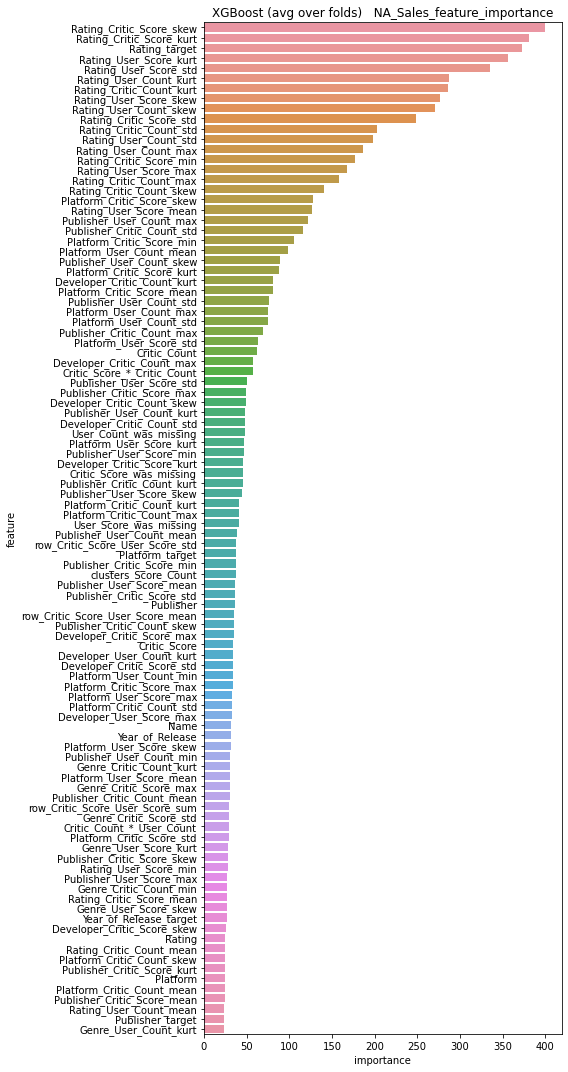

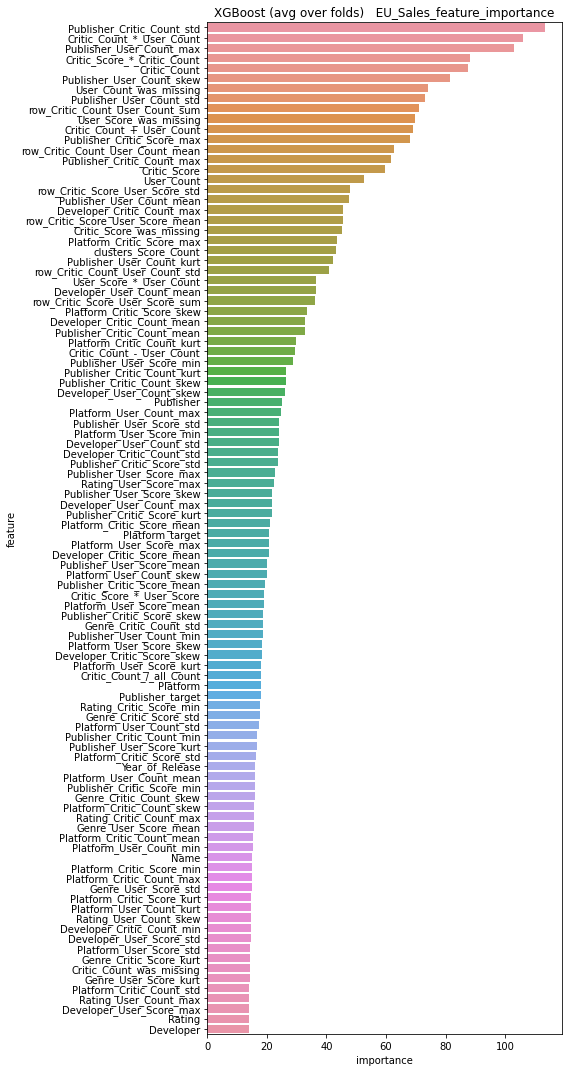

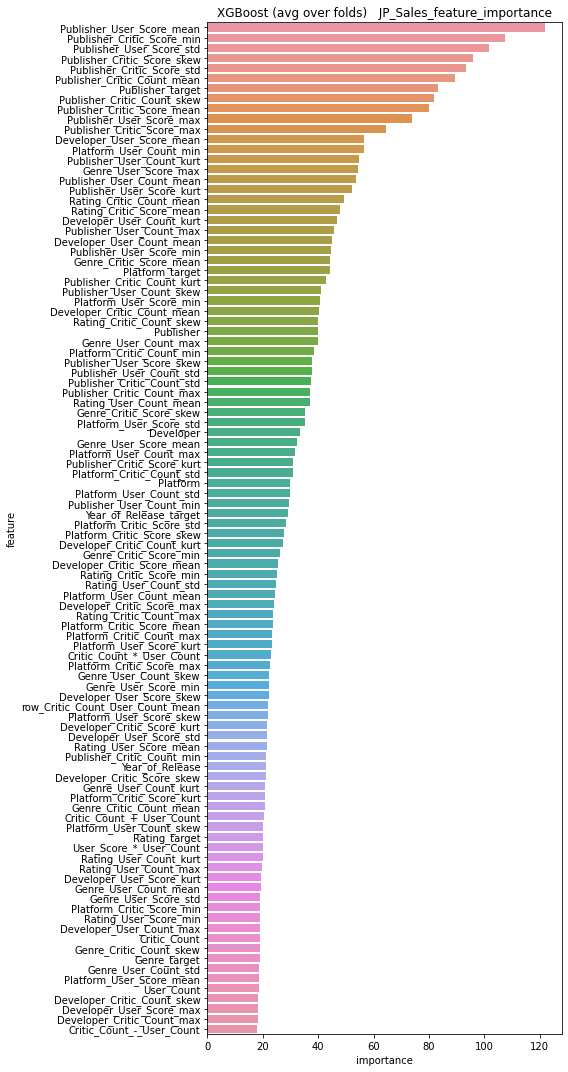

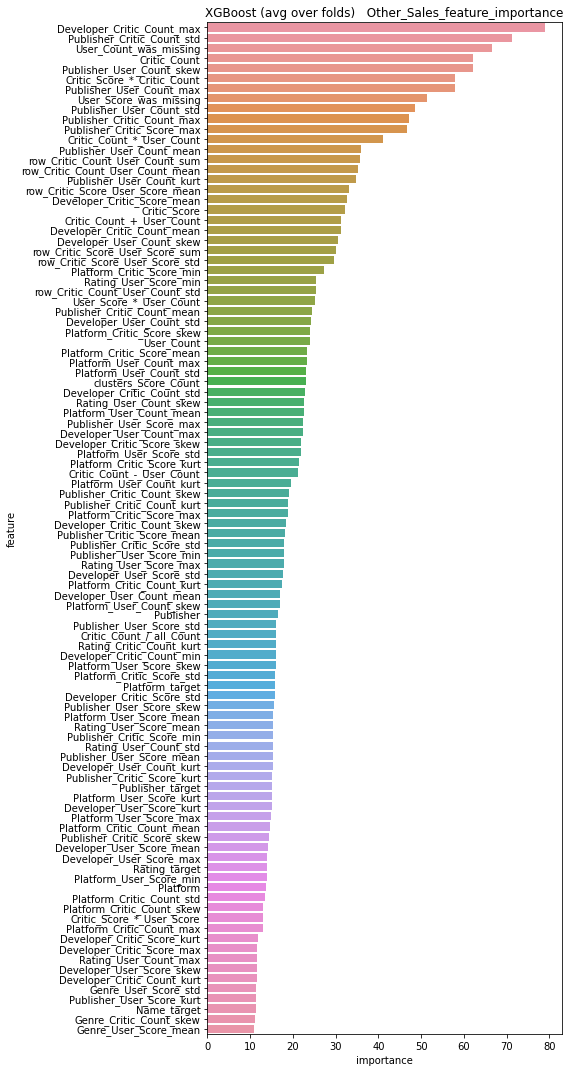

In [61]:
def _importance(features, n_features):
    df_f_imps = None

    for _, tar_col in enumerate(Y.columns):
        imp = f_importance[tar_col]
        df_importance = pd.DataFrame({"feature": imp.index, "importance": imp[tar_col]})
        display_importances(df_importance, png_path=f"{tar_col}_feature_importance")

        if df_f_imps is None:
            df_f_imps = imp
        else:
            df_f_imps = df_f_imps.join(imp)

    df_f_imps.to_csv("feature_importance.csv")
    return df_f_imps


#_importance(features, n_features)
df_f_imps = _importance(features_enc, len(features_enc))
df_f_imps

# oof

In [62]:
#path = r"Y_pred.pkl"
#with open(path, "rb") as f:
#    Y_pred = pickle.load(f)
#Y_pred

# predict test

In [63]:
X_test = test.copy()
Y_test_pred = pd.Series(np.zeros((test.shape[0])))

for i in range(n_seeds):
    for j in range(n_splits):
        for tar_col in Y.columns:
            model_path = f"model_seed_{i}_fold_{j}_{tar_col}.jlb"
            model = joblib.load(model_path)
            
            X_enc, X_test_enc, features_enc = X.copy(), X_test.copy(), features.copy()
            # count_encoder はやめとく。存在しないNameやPublisherなnanaになるので
            #X_enc, X_test_enc, features_enc = count_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            X_enc, X_test_enc, features_enc = target_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            #X_enc, X_test_enc, features_enc = catboost_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            
            #display(X_test_enc.head())
            
            #xgb_tt = xgb.DMatrix(X_test, nthread=-1)
            xgb_tt = xgb.DMatrix(X_test_enc, nthread=-1)

            _y_pred = model.predict(xgb_tt) / (n_seeds * n_splits)
            _y_pred[_y_pred < 0] = 0.0
            
            Y_test_pred += _y_pred
            
print(Y_test_pred.shape)

submission = pd.read_csv(f"{DATADIR}/atmaCup8_sample-submission.csv")
submission["Global_Sales"] = Y_test_pred
submission.to_csv("submission.csv", index=False)
submission

(8360,)


,Global_Sales
0,18.821915
1,26.339753
2,23.466740
3,33.451159
4,28.216061
...,...
8355,8.383812
8356,10.832114
8357,4.496029
8358,4.235673


# psude_label

In [64]:
# 疑似ラベル作成
X_test = test.copy()
Y_test_pred = np.zeros((test.shape[0], n_classes))
Y_test_pred = pd.DataFrame(Y_test_pred, columns=target_cols, index=test.index)

for i in range(n_seeds):
    for j in range(n_splits):
        for tar_col in Y.columns:
            model_path = f"model_seed_{i}_fold_{j}_{tar_col}.jlb"
            model = joblib.load(model_path)
            
            X_enc, X_test_enc, features_enc = X.copy(), X_test.copy(), features.copy()
            # count_encoder はやめとく。存在しないNameやPublisherなnanaになるので
            #X_enc, X_test_enc, features_enc = count_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            X_enc, X_test_enc, features_enc = target_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            #X_enc, X_test_enc, features_enc = catboost_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            
            #display(X_test_enc.head())
            
            #xgb_tt = xgb.DMatrix(X_test, nthread=-1)
            xgb_tt = xgb.DMatrix(X_test_enc, nthread=-1)

            _y_pred = model.predict(xgb_tt) / (n_seeds * n_splits)
            _y_pred[_y_pred < 0] = 0.0
            
            Y_test_pred[tar_col] += _y_pred
Y_test_pred

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,12.499992,5.279745,0.291426,0.750752
1,13.491713,7.575543,1.722700,3.549796
2,13.662932,6.879175,1.470061,1.454572
3,15.665696,11.614013,1.361279,4.810171
4,13.177386,9.365318,1.751693,3.921664
...,...,...,...,...
8355,2.787138,1.220809,3.715376,0.660489
8356,3.748770,2.703701,3.012114,1.367530
8357,1.260305,2.796847,0.092148,0.346729
8358,1.601029,2.048384,0.210840,0.375420


In [65]:
# 疑似ラベル連結
X_test = test.copy()

X = pd.concat([X, X_test], axis=0).reset_index(drop=True)
Y = pd.concat([Y, Y_test_pred], axis=0).reset_index(drop=True)

train_size, n_features = X.shape
#group = X["Name"].copy()
group = X["Publisher"].copy()  # https://www.guruguru.science/competitions/13/discussions/42fc473d-4450-4cfc-b924-0a5d61fd0ca7/
_, n_classes = Y.shape

print(X.shape, Y.shape)

(16719, 150) (16719, 4)


In [66]:
# importance 上位100位までの特徴量だけにする
features_imp = sorted(pd.DataFrame(
    df_f_imps.sum(axis=1)
).sort_values(by=0, ascending=False)[:120].index.to_list())

features_imp

['Critic_Count',
 'Critic_Count_*_User_Count',
 'Critic_Count_+_User_Count',
 'Critic_Count_-_User_Count',
 'Critic_Score',
 'Critic_Score_*_Critic_Count',
 'Critic_Score_was_missing',
 'Developer',
 'Developer_Critic_Count_kurt',
 'Developer_Critic_Count_max',
 'Developer_Critic_Count_mean',
 'Developer_Critic_Count_skew',
 'Developer_Critic_Count_std',
 'Developer_Critic_Score_kurt',
 'Developer_Critic_Score_max',
 'Developer_Critic_Score_mean',
 'Developer_Critic_Score_skew',
 'Developer_Critic_Score_std',
 'Developer_User_Count_kurt',
 'Developer_User_Count_max',
 'Developer_User_Count_mean',
 'Developer_User_Count_skew',
 'Developer_User_Count_std',
 'Developer_User_Score_max',
 'Developer_User_Score_mean',
 'Genre_Critic_Count_kurt',
 'Genre_Critic_Count_skew',
 'Genre_Critic_Score_mean',
 'Genre_Critic_Score_skew',
 'Genre_Critic_Score_std',
 'Genre_User_Count_max',
 'Genre_User_Score_kurt',
 'Genre_User_Score_max',
 'Genre_User_Score_mean',
 'Name',
 'Platform',
 'Platform_Crit

In [67]:
%%time

# 疑似ラベル付けて再学習

Y_pred = np.zeros((train_size, n_classes))
Y_pred = pd.DataFrame(Y_pred, columns=Y.columns, index=Y.index)

for i in tqdm(range(n_seeds)):
    set_seed(seed=i)

    #cv = KFold(n_splits=n_splits, random_state=i, shuffle=shuffle)
    #cv_split = cv.split(X, Y)
    cv = GroupKFold(n_splits=n_splits)
    cv_split = cv.split(X, Y, group)

    for j, (trn_idx, val_idx) in enumerate(cv_split):
        print(f"\n------------ fold:{j} ------------")

        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        Y_train_targets, Y_val_targets = Y.iloc[trn_idx], Y.iloc[val_idx]
    
        for tar, tar_col in enumerate(Y.columns):
            print(f"\n------------ target:{tar_col} ------------")
            Y_train, Y_val = Y_train_targets.values[:, tar], Y_val_targets.values[:, tar]  

            X_train_enc, X_val_enc, features_enc = X_train.copy(), X_val.copy(), features.copy()
            # count_encoder はやめとく。存在しないNameやPublisherなnanaになるので
            #X_train_enc, X_val_enc, features_enc = count_encoder(X_train_enc, Y_train, X_val_enc, Y_val, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            X_train_enc, X_val_enc, features_enc = target_encoder(X_train_enc, Y_train, X_val_enc, Y_val, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            #X_train_enc, X_val_enc, features_enc = catboost_encoder(X_train_enc, Y_train, X_val_enc, Y_val, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            
            # importance 上位100位までの特徴量だけにする
            X_train_enc, X_val_enc = X_train_enc[features_imp], X_val_enc[features_imp]
            
            #display(X_val_enc.head())
            
            #xgb_train  = xgb.DMatrix(X_train, label=Y_train, nthread=-1)
            #xgb_eval = xgb.DMatrix(X_val, label=Y_val, nthread=-1)
            xgb_train  = xgb.DMatrix(X_train_enc, label=Y_train, nthread=-1)
            xgb_eval = xgb.DMatrix(X_val_enc, label=Y_val, nthread=-1)

            model = xgb.train(
                    params, 
                    xgb_train, 
                    n_estimators, 
                    [(xgb_eval, 'eval')],
                    early_stopping_rounds=early_stopping_rounds,
                    verbose_eval=verbose_eval,
                )
            
            Y_pred[tar_col][val_idx] += model.predict(xgb_eval, ntree_limit=model.best_ntree_limit) / n_seeds

            joblib.dump(model, f"model_seed_{i}_fold_{j}_{tar_col}.jlb", compress=True)

for col in Y.columns:
    idx = Y_pred[Y_pred[col] < 0].index
    Y_pred[col][idx] = 0.0
    
with open("Y_pred_psude_label.pkl", "wb") as f:
    pickle.dump(Y_pred.iloc[: train.shape[0]], f)
    


------------ fold:0 ------------

------------ target:NA_Sales ------------
[0]	eval-rmsle:2.18475
Will train until eval-rmsle hasn't improved in 100 rounds.
[100]	eval-rmsle:1.55680
[200]	eval-rmsle:1.12607
[300]	eval-rmsle:0.90458
[400]	eval-rmsle:0.82114
[500]	eval-rmsle:0.79186
[600]	eval-rmsle:0.78004
[700]	eval-rmsle:0.77249
[800]	eval-rmsle:0.77025
[900]	eval-rmsle:0.76889
[1000]	eval-rmsle:0.76883
Stopping. Best iteration:
[945]	eval-rmsle:0.76863


------------ target:EU_Sales ------------
[0]	eval-rmsle:1.63281
Will train until eval-rmsle hasn't improved in 100 rounds.
[100]	eval-rmsle:1.16322
[200]	eval-rmsle:0.90162
[300]	eval-rmsle:0.79059
[400]	eval-rmsle:0.75231
[500]	eval-rmsle:0.74095
[600]	eval-rmsle:0.73589
[700]	eval-rmsle:0.73411
[800]	eval-rmsle:0.73315
[900]	eval-rmsle:0.73267
Stopping. Best iteration:
[879]	eval-rmsle:0.73256


------------ target:JP_Sales ------------
[0]	eval-rmsle:0.87912
Will train until eval-rmsle hasn't improved in 100 rounds.
[100]	eval-

[1100]	eval-rmsle:0.62981
[1200]	eval-rmsle:0.62971
[1300]	eval-rmsle:0.62965
[1400]	eval-rmsle:0.62961
[1500]	eval-rmsle:0.62919
[1600]	eval-rmsle:0.62884
[1700]	eval-rmsle:0.62880
[1800]	eval-rmsle:0.62859
[1900]	eval-rmsle:0.62843
[2000]	eval-rmsle:0.62838
[2100]	eval-rmsle:0.62828
[2200]	eval-rmsle:0.62814
[2300]	eval-rmsle:0.62813
[2400]	eval-rmsle:0.62814
Stopping. Best iteration:
[2351]	eval-rmsle:0.62810


------------ target:Other_Sales ------------
[0]	eval-rmsle:0.79668
Will train until eval-rmsle hasn't improved in 100 rounds.
[100]	eval-rmsle:0.60414
[200]	eval-rmsle:0.53380
[300]	eval-rmsle:0.51516
[400]	eval-rmsle:0.51122
[500]	eval-rmsle:0.51058
Stopping. Best iteration:
[444]	eval-rmsle:0.51037


Wall time: 1min 51s


In [68]:
score(Y.iloc[: train.shape[0]], Y_pred.iloc[: train.shape[0]])

NA_Sales       1.354896
EU_Sales       1.256088
JP_Sales       1.168773
Other_Sales    0.851519
dtype: float64

In [69]:
score(Y_global, Y_pred.iloc[: train.shape[0]].sum(axis=1))

1.2399776597015906

In [70]:
# predict test

X_test = test.copy()
Y_test_pred = pd.Series(np.zeros((test.shape[0])))

for i in range(n_seeds):
    for j in range(n_splits):
        for tar_col in Y.columns:
            model_path = f"model_seed_{i}_fold_{j}_{tar_col}.jlb"
            model = joblib.load(model_path)
            
            X_enc, X_test_enc, features_enc = X.copy(), X_test.copy(), features.copy()
            # count_encoder はやめとく。存在しないNameやPublisherなnanaになるので
            #X_enc, X_test_enc, features_enc = count_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            X_enc, X_test_enc, features_enc = target_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            #X_enc, X_test_enc, features_enc = catboost_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            
            # importance 上位100位までの特徴量だけにする
            X_test_enc = X_test_enc[features_imp]
            
            #display(X_test_enc.head())
            
            #xgb_tt = xgb.DMatrix(X_test, nthread=-1)
            xgb_tt = xgb.DMatrix(X_test_enc, nthread=-1)

            _y_pred = model.predict(xgb_tt) / (n_seeds * n_splits)
            _y_pred[_y_pred < 0] = 0.0
            
            Y_test_pred += _y_pred
            
print(Y_test_pred.shape)

submission = pd.read_csv(f"{DATADIR}/atmaCup8_sample-submission.csv")
submission["Global_Sales"] = Y_test_pred
submission.to_csv("submission_psude_label.csv", index=False)
submission

(8360,)


,Global_Sales
0,19.658886
1,25.653658
2,23.786079
3,34.704825
4,27.925709
...,...
8355,9.166377
8356,10.518983
8357,5.454036
8358,4.845981
